# MLP Model

### Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [3]:
chars = ["."] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}

### Hyperparameters

In [4]:
block_size = 5
embedding_size = 8
hidden_layer_size = 200
batch_size = 128

### Build dataset

In [5]:
def build_dataset(words, block_size=3, verbose=False):
    X, Y = [], []
    for word in words:
        padded_word = ["."] * block_size + list(word) + ["."]
        for i in range(len(padded_word)-block_size):
            context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
            target = char_to_ix[padded_word[i+block_size]]
            X.append(context), Y.append(target)
    X, Y = torch.tensor(X), torch.tensor(Y)
    if verbose:
        print(f"{X.shape}\t{Y.shape}")
    return X, Y

random.seed(5)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size=block_size, verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size, verbose=True)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size, verbose=True)

torch.Size([182558, 5])	torch.Size([182558])
torch.Size([22712, 5])	torch.Size([22712])
torch.Size([22876, 5])	torch.Size([22876])


### Find an appropriate learning rate

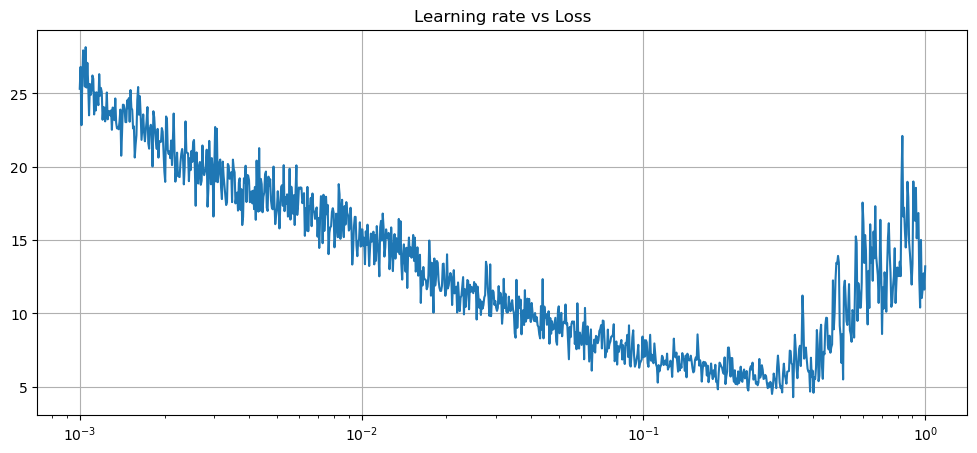

In [6]:
# initialize parameters
g = torch.Generator().manual_seed(5)
C = torch.randn((len(chars), embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((block_size*embedding_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, len(chars)), requires_grad=True, generator=g)
b2 = torch.randn((len(chars)), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

# candidate learning rates that we want to search over
lrs = torch.logspace(start=-3, end=0, steps=1000) # or use `torch.logspace`

loss_i = []
for i in range(len(lrs)):
    
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X_tr[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= lrs[i] * p.grad
    
    # track stats
    loss_i.append(loss.item())

plt.figure(figsize=(12,5)); plt.title("Learning rate vs Loss"); plt.plot(lrs, loss_i); plt.grid(); plt.xscale("log");

In [11]:
10**(-0.9)

0.12589254117941673

### Train

In [8]:
def evaluate(X, Y):
    emb = C[X]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [12]:
# initialize parameters
g = torch.Generator().manual_seed(5)
C = torch.randn((len(chars), embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((block_size*embedding_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, len(chars)), requires_grad=True, generator=g)
b2 = torch.randn((len(chars)), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

In [13]:
# initialize trackers
losses = []
counter = 0

In [25]:
learning_rate = 0.01

for step in range(30_000):
    
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X_tr[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    losses.append(loss.item())
    counter += 1
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= learning_rate * p.grad

print(f"Training split loss: {evaluate(X_tr, Y_tr):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 2.1323
Development split loss: 2.1659


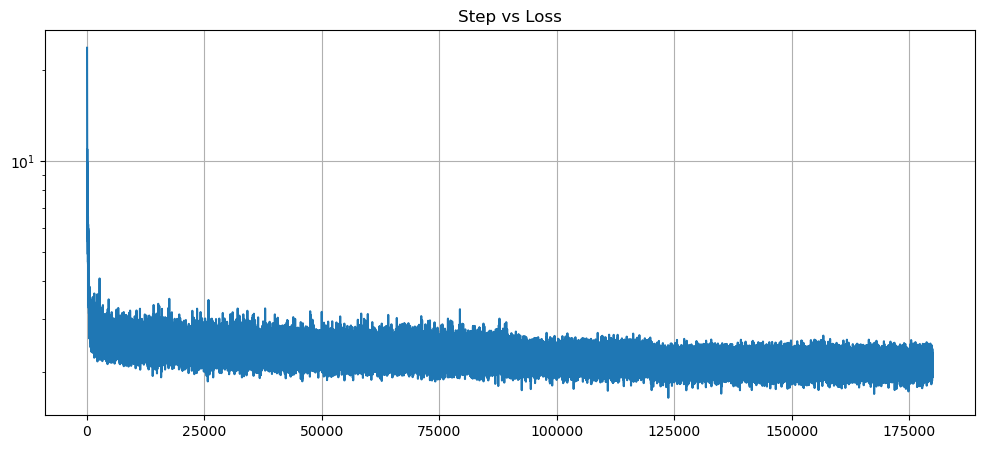

In [26]:
plt.figure(figsize=(12,5)); plt.title("Step vs Loss"); plt.plot(range(counter), losses); plt.grid(); plt.yscale("log");

### Evaluate

In [27]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 2.1678


In [28]:
g = torch.Generator().manual_seed(5)
for _ in range(20):
    context = ["."] * block_size
    out = []
    while True:
        emb = C[torch.tensor([char_to_ix[char] for char in context])]
        h_in = emb.view(-1, block_size * embedding_size)
        h_out = torch.tanh(h_in @ W1 + b1)
        logits = h_out @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix==0:
            break
        char = ix_to_char[ix]
        context = context[1:] + [char]
        out.append(char)
    print("".join(out), end="\n")

karyi
dipara
esha
gaydon
rihan
blichten
alyonna
payoa
medan
hucin
aryleen
kodich
annylan
amacodecos
zahaa
cta
rleira
tamy
broo
gerin
